bc friend wanted to sell car

<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>What is the Value of Your Car?</h1>
</div>

[Original Dataset](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/data)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from statsmodels.stats.outliers_influence import variance_inflation_factor

import re
import joblib


In [2]:
df = pd.read_csv('used_cars.csv')
df.sample(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
3614,Porsche,911 Turbo Cabriolet,2009,"13,500 mi.",Gasoline,480.0HP 3.6L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,"$130,000"
1596,Ford,Expedition XLT,2022,"22,169 mi.",Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Black,Sandstone,None reported,Yes,"$57,352"


#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Data Cleaning</h1>
  <ul>
    <li>Make data types reasonable</li>
    <li>Extract metadata from existing features</li>
  </ul>
</div>

In [3]:
def get_df_info(df):
    """ 
    Function to see information in `df`. Contains all information
    in `df.info()` but more. Use this function to save space. 

    Parameters
    ----------
    df (pd.DataFrame): DataFrame for which you want information. 

    Returns
    -------
    df_info (pd.DataFrame): DataFrame with information about `df`. 

    """
    df_info = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Dtype': df.dtypes.values,
        'Unique Value Count': df.nunique().values,
        'Missing Count': df.isna().sum().values
    })
    return df_info

get_df_info(df)

,Column,Non-Null Count,Dtype,Unique Value Count,Missing Count
0,brand,4009,object,57,0
1,model,4009,object,1898,0
2,model_year,4009,int64,34,0
3,milage,4009,object,2818,0
4,fuel_type,3839,object,7,170
5,engine,4009,object,1146,0
6,transmission,4009,object,62,0
7,ext_col,4009,object,319,0
8,int_col,4009,object,156,0
9,accident,3896,object,2,113


Drop `model` column because:
* values are sparse 
* there are too many unique values, which might lead to overfiaccidenting
* no apparent pattern in the column (e.g. 'blue, 2000' where I can extract 'color' and 'year')

In [4]:
print(f'Highest-occurring value: {max(df['model'].value_counts())}')
df.drop('model', axis=1, inplace=True) 

Highest-occurring value: 30


In [5]:
# Make `mileage` numeric
df.rename(columns={'milage': 'mileage'}, inplace=True)
df['mileage'] = df['mileage'].str.strip().str.rstrip(' mi.').str.replace(',', '', regex=True).astype(int)

# Extract info from `engine` column
df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP', expand=False) # Extract horsepower
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

df['engine_size'] = df['engine'].str.extract(r'(\d+\.\d+L|\d+\.\d+ Liter)', expand=False)  # Extract engine size
df['engine_size'] = df['engine_size'].str.extract(r'(\d+\.\d+|\d+)').astype(float)  

df['cylinders'] = df['engine'].str.extract(r'(V\d+|\d+ Cylinder)', expand=False)  # Extract cylinder
df['cylinders'] = df['cylinders'].str.extract(r'(\d+)').astype(float) 

df.drop('engine', axis=1, inplace=True)

def extract_transmission_type(transmission):
        if 'Automatic' in transmission or 'A/T' in transmission:
            return 'Automatic'
        elif 'Manual' in transmission or 'M/T' in transmission:
            return 'Manual'
        else:
            return 'None'  
        
df['transmission_type'] = df['transmission'].apply(extract_transmission_type)   
df.drop('transmission', axis=1, inplace=True)

# Make `accident` boolean
df['accident'] = df['accident'].map({'At least 1 accident or damage reported': 'yes',
                                     'None reported': 'no'})

# Drop `clean_title` because only 1 value
df.drop('clean_title', axis=1, inplace=True)

# Make `price` numeric
df['price'] = df['price'].str.lstrip('$').str.replace(',', '').astype(int)

#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Exploratory Data Analysis (EDA)</h1>
</div>

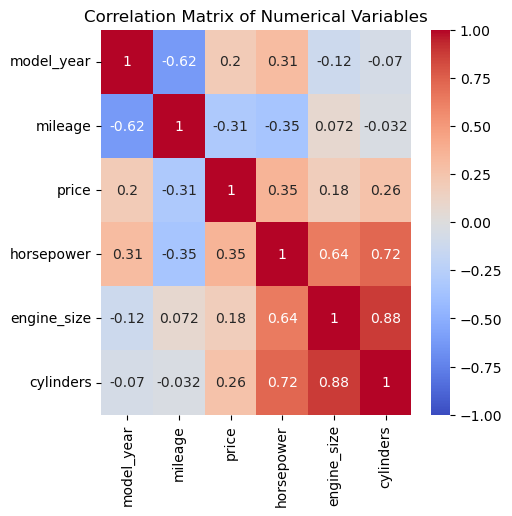

In [6]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

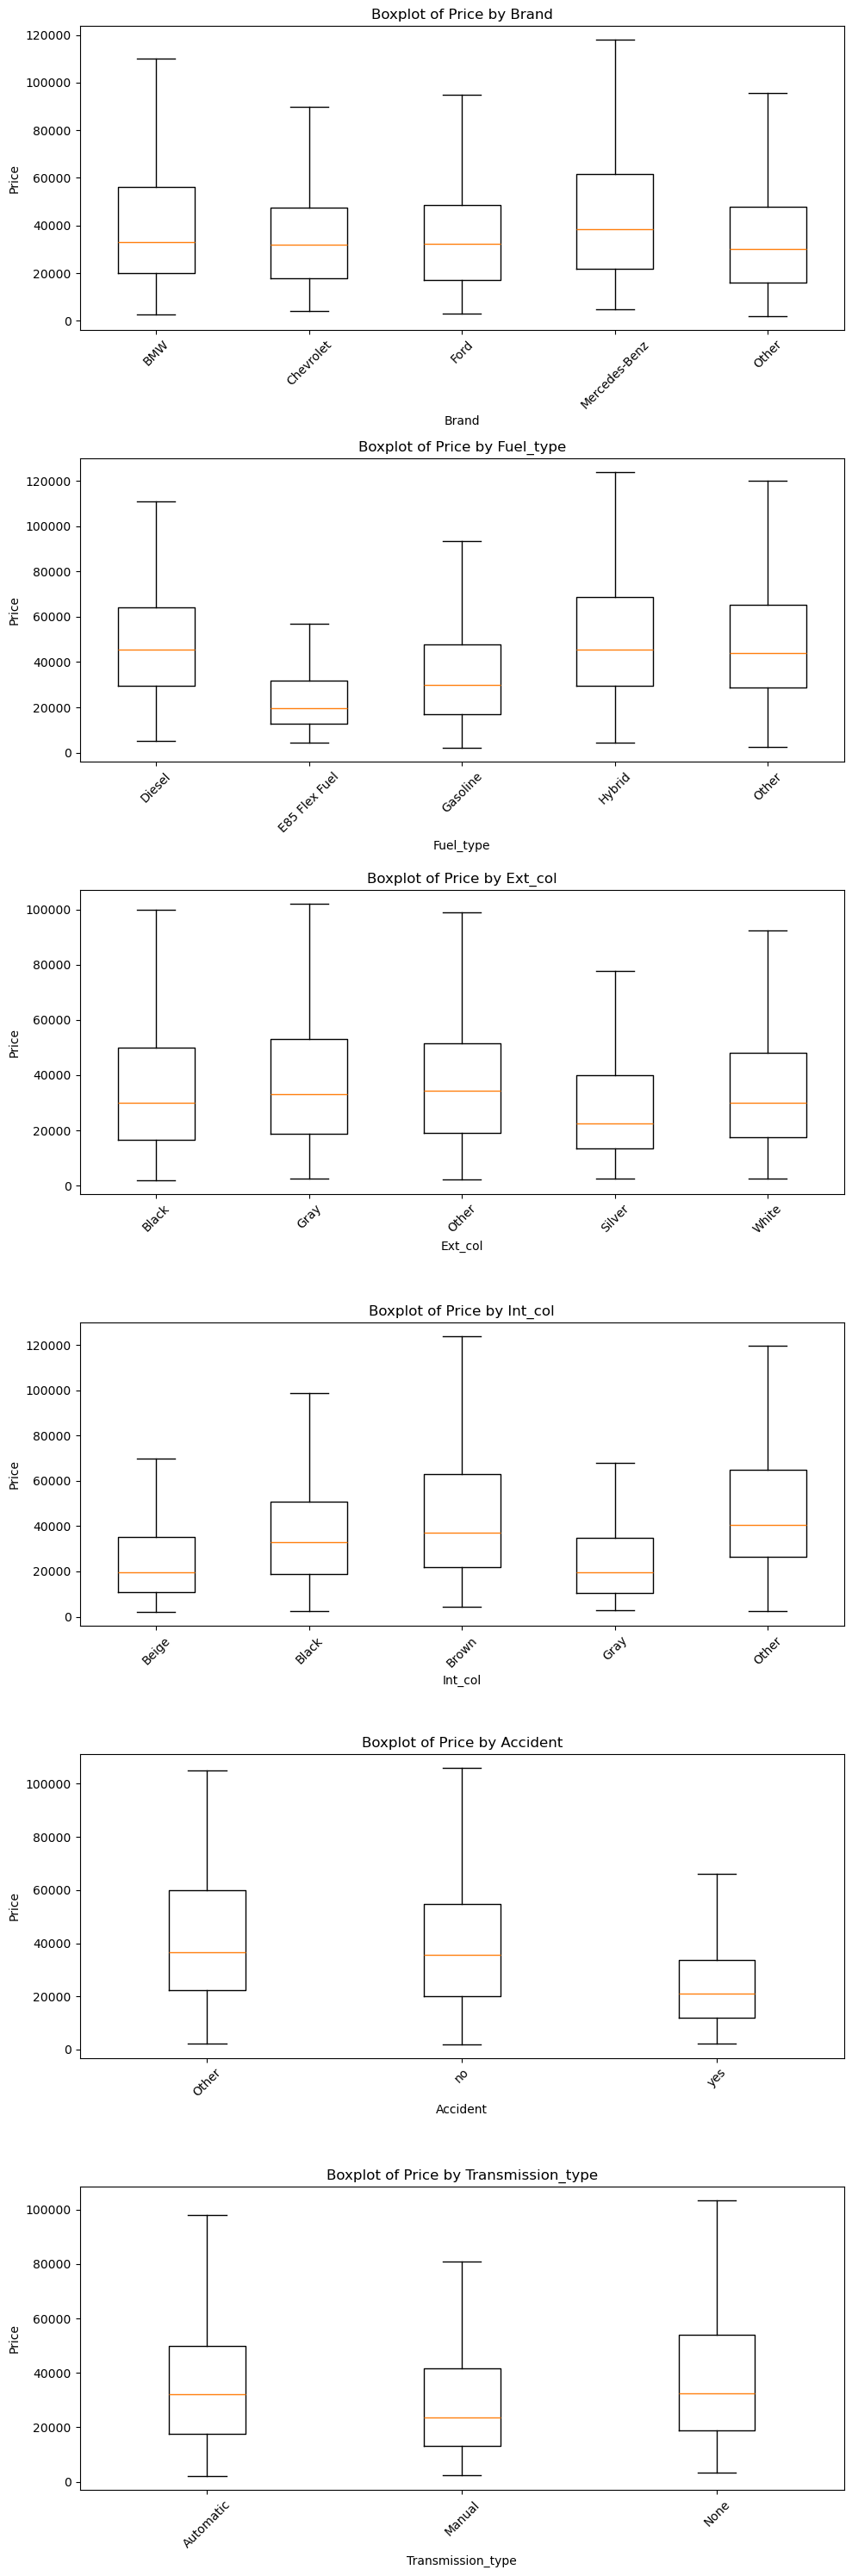

In [7]:
def make_boxplots(df, response, top_n=5):
    """" 
    Make side-by-side boxplots for non-numeric features. 
    If feature has too many levels to visualize (more than `top_n`),
    put it in `Other`.

    Parameters
    ----------
        - df (pd.DataFrame): DataFrame you want to visualize
        - response (str): Name of response feature
        - top_n (int): Max number of boxplots per plot

    Returns
    -------
    None. Displayed side-by-side boxplots for each non-numeric feature. 

    """
    non_numeric_features = df.select_dtypes(exclude=['number']).columns

    fig, axes = plt.subplots(
        nrows=len(non_numeric_features), 
        figsize=(10, 5 * len(non_numeric_features)), 
        squeeze=False
    )
    
    for idx, feature in enumerate(non_numeric_features):
        # Get the top categories based on counts
        top_categories = df[feature].value_counts().nlargest(top_n - 1).index
        
        # Replace levels not in the top categories with 'Other'
        plot_data = df.copy()
        plot_data['temp_feature'] = plot_data[feature].apply(lambda x: x if x in top_categories else 'Other')
        
        # Group data by 'temp_feature'
        grouped_data = plot_data.groupby('temp_feature')[response]
        categories = list(grouped_data.groups.keys())
        data = [grouped_data.get_group(cat).values for cat in categories]
        
        axes[idx, 0].boxplot(data, labels=categories, showfliers=False)
        axes[idx, 0].set_title(f'Boxplot of {response.capitalize()} by {feature.capitalize()}')
        axes[idx, 0].set_xlabel(feature.capitalize())
        axes[idx, 0].set_ylabel(response.capitalize())
        axes[idx, 0].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

make_boxplots(df, response='price', top_n=5)

/var/folders/_j/pzs88x3s1fv95pbq0f9_m8dm0000gn/T/ipykernel_6812/127633960.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g*" (-> color='g'). The keyword argument will take precedence.
  plt.plot(i, mean, 'g*', markersize=12, color='black', label='Mean' if i == 1 else "")


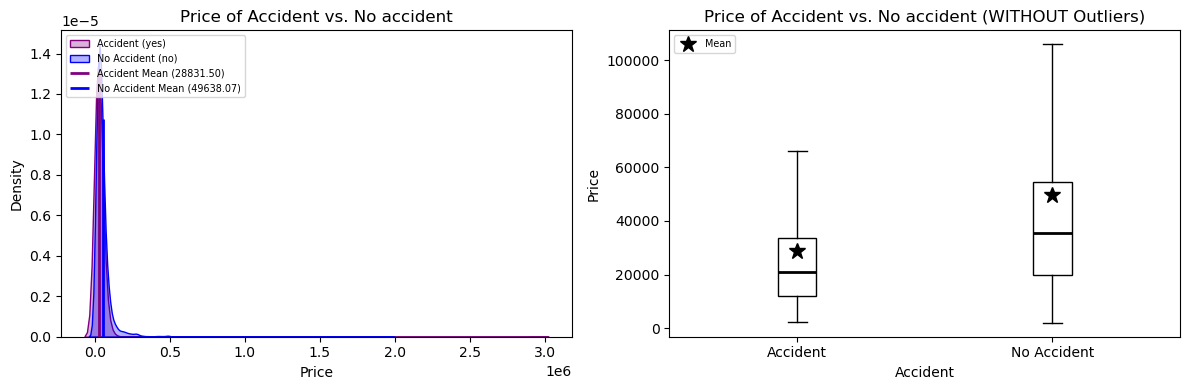

In [8]:
def plot_browse_time_comparison(df, category_col, value_col, category_a, category_b, label_a='A', label_b='B'):
    """
    Plots KDE and boxplots comparing two categories (A and B) for a given value column.

    Parameters
    ----------
        - df (pd.DataFrame): DataFrame containing the data
        - category_col (str): Column name representing the categories
        - value_col (str): Column name representing the values to compare
        - category_a (str): Value in category_col corresponding to Category A
        - category_b (str): Value in category_col corresponding to Category B
        - label_a (str): Label for Category A (default: 'A')
        - label_b (str): Label for Category B (default: 'B')

    Returns
    -------
    None. Displays plots. 

    """
    # Extract data for each category
    data_a = df[df[category_col] == category_a][value_col]
    data_b = df[df[category_col] == category_b][value_col]

    plt.figure(figsize=(12, 4))

    # KDE Plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(data_a, label=f"{label_a} ({category_a})", color='purple', fill=True, alpha=0.3)
    sns.kdeplot(data_b, label=f"{label_b} ({category_b})", color='blue', fill=True, alpha=0.3)

    kde_a = gaussian_kde(data_a)
    kde_b = gaussian_kde(data_b)
    a_mean = data_a.mean()
    b_mean = data_b.mean()
    a_density_at_mean = kde_a(a_mean)
    b_density_at_mean = kde_b(b_mean)
    plt.vlines(x=a_mean, ymin=0, ymax=a_density_at_mean, color="purple", linewidth=2, label=f"{label_a} Mean ({a_mean:.2f})")
    plt.vlines(x=b_mean, ymin=0, ymax=b_density_at_mean, color="blue", linewidth=2, label=f"{label_b} Mean ({b_mean:.2f})")

    plt.title(f"{value_col.capitalize()} of {label_a.capitalize()} vs. {label_b.capitalize()}")
    plt.xlabel(f"{value_col.capitalize()}")
    plt.ylabel("Density")
    plt.legend(loc='upper left', fontsize='x-small')

    # Boxplot
    plt.subplot(1, 2, 2)
    browse_times = [data_a, data_b]
    labels = [label_a, label_b]
    boxprops = dict(facecolor='white', color='black')
    medianprops = dict(color='black', linewidth=2)
    plt.boxplot(
        browse_times,
        labels=labels,
        vert=True,
        patch_artist=True,
        boxprops=boxprops,
        medianprops=medianprops,
        showfliers=False
    )

    for i, data in enumerate(browse_times, start=1):
        mean = np.mean(data)
        plt.plot(i, mean, 'g*', markersize=12, color='black', label='Mean' if i == 1 else "")

    plt.title(f'{value_col.capitalize()} of {label_a.capitalize()} vs. {label_b.capitalize()} (WITHOUT Outliers)')
    plt.xlabel(f'{category_col.capitalize()}')
    plt.ylabel(f'{value_col.capitalize()}')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.tight_layout()
    plt.show()

plot_browse_time_comparison(df,
                            category_col='accident',
                            value_col='price', 
                            category_a='yes', 
                            category_b='no',
                            label_a='Accident', 
                            label_b='No Accident')

/var/folders/_j/pzs88x3s1fv95pbq0f9_m8dm0000gn/T/ipykernel_6812/127633960.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g*" (-> color='g'). The keyword argument will take precedence.
  plt.plot(i, mean, 'g*', markersize=12, color='black', label='Mean' if i == 1 else "")


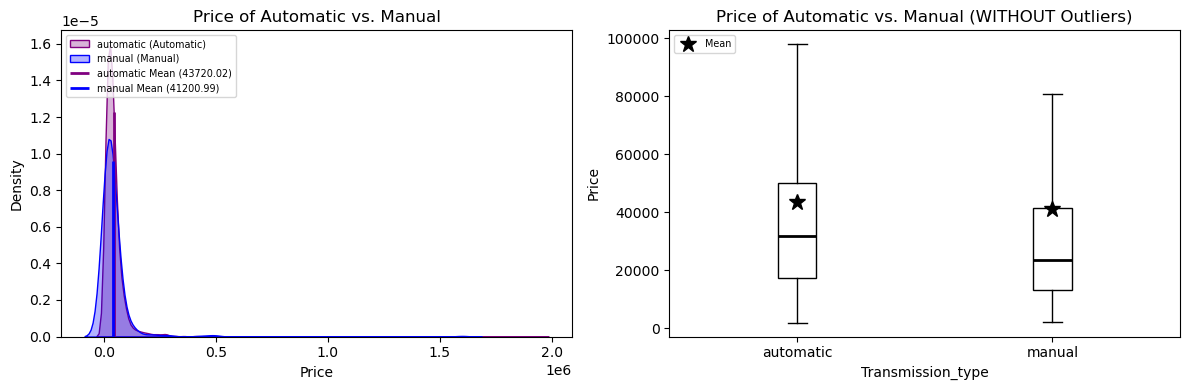

In [9]:
plot_browse_time_comparison(df,
                            category_col='transmission_type',
                            value_col='price', 
                            category_a='Automatic', 
                            category_b='Manual',
                            label_a='automatic', 
                            label_b='manual')

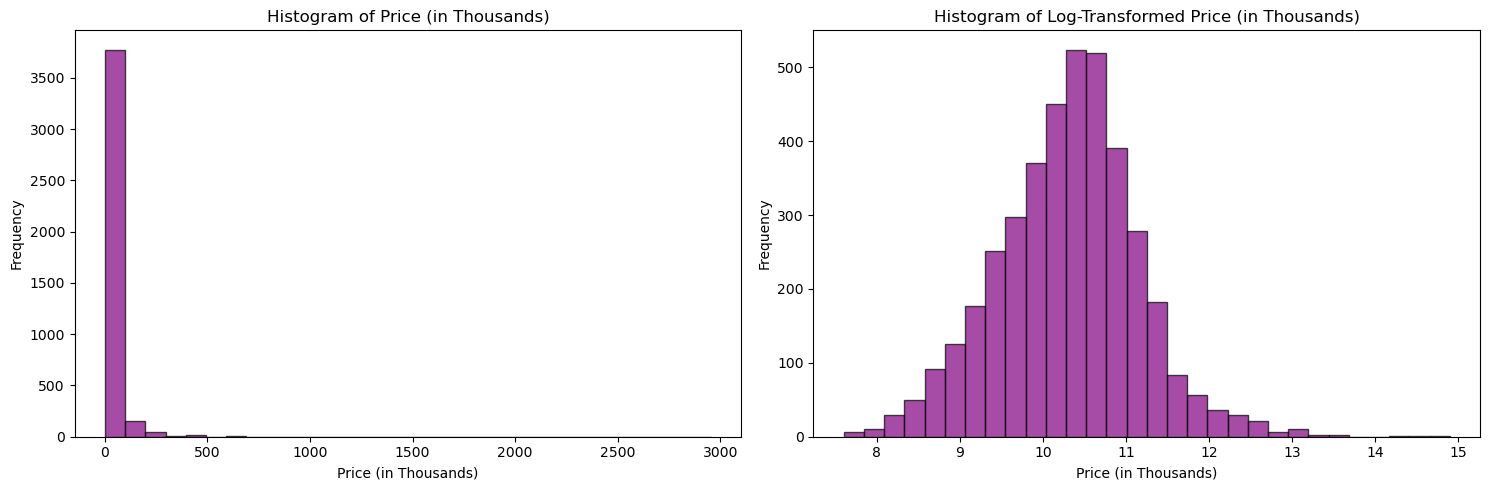

In [10]:
price_k = df['price'] / 1000  # Price in thousands

background, plots = plt.subplots(1, 2, figsize=(15, 5))  

# Price (untransformed)
plots[0].hist(price_k, bins=30, alpha=0.7, 
              color='purple', edgecolor='black')
plots[0].set_ylabel('Frequency')
plots[0].set_xlabel('Price (in Thousands)')
plots[0].set_title('Histogram of Price (in Thousands)')

# Price (transformed)
plots[1].hist(np.log1p(df['price']), bins=30, alpha=0.7, 
              color='purple', edgecolor='black')
plots[1].set_ylabel('Frequency')
plots[1].set_xlabel('Price (in Thousands)')
plots[1].set_title('Histogram of Log-Transformed Price (in Thousands)')

plt.tight_layout()
plt.show()


The data is very right-skewed (as with most things related to price). 

Do data splitting here because the data preprocessing steps I'm about to do would cause data leakage if I use entire dataset. All the data preprocessing up until now doesn't cause data leakage.

In [11]:
X = df.drop('price', axis=1)
# y = df['price'] # don't use, has low model performance
y = np.log1p(df['price']) # this one has MUCH better model performance

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,brand,model_year,mileage,fuel_type,ext_col,int_col,accident,horsepower,engine_size,cylinders,transmission_type
2473,Ford,2018,73049,Gasoline,Gray,Ebony Black,yes,NaN,3.5,6.0,Automatic
1338,GMC,2023,9980,Gasoline,Black,Black,no,355.0,5.3,8.0,Automatic
1613,BMW,2016,55250,Gasoline,Blue,White,no,425.0,3.0,6.0,Manual
1610,Lexus,2017,77300,Gasoline,White,Black,no,306.0,3.5,6.0,Automatic
2600,Ford,2018,33700,E85 Flex Fuel,Gray,Black,yes,160.0,2.0,4.0,Automatic
...,...,...,...,...,...,...,...,...,...,...,...
1130,Buick,2006,110000,Gasoline,Gold,Beige,no,275.0,4.6,8.0,Automatic
1294,Chevrolet,1995,120000,–,White,Brown,yes,NaN,NaN,NaN,Automatic
860,Mitsubishi,2016,131193,Gasoline,Black,Black,no,NaN,2.4,NaN,Automatic
3507,Ford,2018,48619,Gasoline,Gray,White,no,400.0,3.5,6.0,Automatic


In [12]:
X_numeric = X_train.select_dtypes(include=[np.number])
X_numeric = X_numeric.dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
vif_data

,feature,VIF
0,model_year,20.691530
1,mileage,3.833525
2,horsepower,25.869522
3,engine_size,37.470203
4,cylinders,87.381441


In [13]:
X_train.drop(['fuel_type', 'cylinders'], axis=1, inplace=True)
X_test.drop(['fuel_type', 'cylinders'], axis=1, inplace=True)

X_test

,brand,model_year,mileage,ext_col,int_col,accident,horsepower,engine_size,transmission_type
2580,Lexus,2018,50992,White,Gray,yes,260.0,3.5,Automatic
3660,Chevrolet,2004,64500,Beige,Beige,no,180.0,3.4,Automatic
897,RAM,2017,86000,Gray,Gray,yes,350.0,6.7,Automatic
2091,Mercedes-Benz,2013,24933,Silver,Red,yes,429.0,4.6,None
1044,Ford,2018,18500,Blue,Black,yes,526.0,5.2,Manual
...,...,...,...,...,...,...,...,...,...
283,Jeep,2022,8794,White,Black,no,285.0,3.6,Automatic
712,Maserati,2023,2200,Black,Red,no,325.0,2.0,None
274,Porsche,2019,6700,Gray,Black,no,300.0,2.0,Automatic
2279,Land,2019,52300,Black,Black,no,340.0,3.0,None


#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Feature Engineering</h1>
  <ul>
    <li>Handle missing values</li>
    <li>Normalize numeric data</li>
    <li>Encode non-numeric data</li>
  </ul>
</div>

In [14]:
def impute_knn_numeric(df, n_neighbors=5):
    """
    Function to impute missing values in numeric columns using KNN Imputer.

    Advantages of this approach:
    ---------------------------
        - Leverages feature similarity for numeric imputation
        - Preserves relationships in numeric data

    Parameters
    ----------
        - df (pd.DataFrame): DataFrame for imputing values
        - n_neighbors (int): Number of nearest neighbors to use for numeric imputation

    Returns
    -------
    df_imputed (pd.DataFrame): DataFrame with numeric columns imputed

    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )

    df_imputed = pd.concat([df_numeric_imputed, df[non_numeric_cols]], axis=1)
    return df_imputed


def impute_categorical_missing(df, placeholder="Not Reported"):
    """
    Function to fill missing values in categorical columns with a placeholder.

    Parameters
    ----------
        - df (pd.DataFrame): DataFrame containing mixed data types
        - placeholder (str): Placeholder value to use for imputation (default: "Not Reported")

    Returns
    -------
    df (pd.DataFrame): DataFrame with categorical missing values filled

    """
    categorical_cols = df.select_dtypes(exclude=['number']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(placeholder)

    return df


X_train = impute_knn_numeric(X_train)
X_test = impute_knn_numeric(X_test)

X_train = impute_categorical_missing(X_train, placeholder="Not Reported")
X_test = impute_categorical_missing(X_test, placeholder="Not Reported")

Note: `drop_first=True` is dummy encoding (i.e. there's an "reference" or "default" level), and `drop_first=False` is true one-hot encoding (i.e. there's a column for each level)


In [15]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
non_numeric_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Scale Numeric Features
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
joblib.dump(scaler, 'scaler.pkl')

# Label Encode Non-Numeric Features
label_encoders = {}  # Store encoders for each feature

# Encode X_train
for feature in non_numeric_features:
    encoder = LabelEncoder()
    X_train[feature] = encoder.fit_transform(X_train[feature])
    label_encoders[feature] = encoder  # Save encoder for future use

# Encode X_test, map unseen categories to -1
for feature in non_numeric_features:
    encoder = label_encoders[feature]
    X_test[feature] = X_test[feature].map(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [16]:
X_train.head()

,model_year,mileage,horsepower,engine_size,brand,ext_col,int_col,accident,transmission_type
2473,0.404894,0.154635,0.474028,-0.135546,13,106,54,2,0
1338,1.233863,-1.048390,0.131239,1.168305,14,22,13,1,0
1613,0.073307,-0.184876,0.737178,-0.497727,4,31,131,1,1
1610,0.239101,0.235722,-0.292918,-0.135546,26,256,13,1,0
2600,0.404894,-0.595937,-1.556732,-1.222089,13,106,13,2,0


In [17]:
get_df_info(X_train)

,Column,Non-Null Count,Dtype,Unique Value Count,Missing Count
0,model_year,3207,float64,34,0
1,mileage,3207,float64,2314,0
2,horsepower,3207,float64,701,0
3,engine_size,3207,float64,146,0
4,brand,3207,int64,56,0
5,ext_col,3207,int64,271,0
6,int_col,3207,int64,135,0
7,accident,3207,int64,3,0
8,transmission_type,3207,int64,3,0


In [18]:
X_test.head()

,model_year,mileage,horsepower,engine_size,brand,ext_col,int_col,accident,transmission_type
2580,0.404894,-0.266096,-0.691106,-0.135546,26,256,63,2,0
3660,-1.916217,-0.008435,-1.383607,-0.207982,8,18,9,1,0
897,0.239101,0.401672,0.087958,2.182412,43,106,63,2,0
2091,-0.424074,-0.763165,0.771803,0.661252,35,219,101,2,2
1044,0.404894,-0.885873,1.611461,1.095869,13,31,13,2,1


In [19]:
get_df_info(X_test)

,Column,Non-Null Count,Dtype,Unique Value Count,Missing Count
0,model_year,802,float64,30,0
1,mileage,802,float64,692,0
2,horsepower,802,float64,334,0
3,engine_size,802,float64,96,0
4,brand,802,int64,49,0
5,ext_col,802,int64,57,0
6,int_col,802,int64,35,0
7,accident,802,int64,3,0
8,transmission_type,802,int64,3,0


#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Model</h1>
  <ul>
    <li>Linear Regression</li>
    <li>Lasso</li>
    <li>Random Forest</li>
  </ul>
</div>

# Linear Regression

In [20]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predictions for Train and Test
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

# Metrics for Training Set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Metrics for Test Set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create metrics DataFrame
linear_reg_metrics = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAE", "R²"],
    "Train": [train_mse, train_rmse, train_mae, train_r2],
    "Test": [test_mse, test_rmse, test_mae, test_r2]
})

linear_reg_metrics

,Metric,Train,Test
0,MSE,0.192028,0.233784
1,RMSE,0.438210,0.483512
2,MAE,0.318320,0.328941
3,R²,0.728905,0.699770


# Lasso CV

In [21]:
lasso_cv = LassoCV(
    alphas=np.linspace(0.01, 10, 100),  
    cv=5,
    random_state=42
)
lasso_cv.fit(X_train, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

# Predictions for Train and Test
y_train_pred = lasso_cv.predict(X_train)
y_test_pred = lasso_cv.predict(X_test)

# Metrics for Training Set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Metrics for Test Set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

lasso_cv_metrics = pd.DataFrame({"Metric": ["MSE", "RMSE", "MAE", "R²"],
                                 "Train": [train_mse, train_rmse, train_mae, train_r2],
                                 "Test": [test_mse, test_rmse, test_mae, test_r2]})
lasso_cv_metrics

Optimal alpha: 0.01


,Metric,Train,Test
0,MSE,0.192925,0.235717
1,RMSE,0.439233,0.485506
2,MAE,0.318127,0.328933
3,R²,0.727638,0.697288


# Random Forest

In [22]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=100,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

# Predictions for Train and Test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metrics for Training Set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Metrics for Testing Set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

rf_metrics = pd.DataFrame({"Metric": ["MSE", "RMSE", "MAE", "R²"],
                           "Train": [train_mse, train_rmse, train_mae, train_r2],
                           "Test": [test_mse, test_rmse, test_mae, test_r2]})
rf_metrics

,Metric,Train,Test
0,MSE,0.074792,0.175462
1,RMSE,0.273481,0.418882
2,MAE,0.194649,0.275294
3,R²,0.894413,0.774668


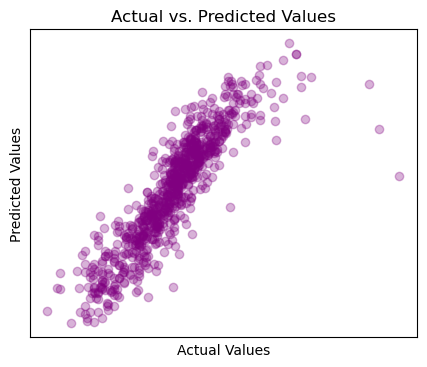

In [23]:
# Compare actual vs predicted values for Random Forest
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='purple')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.xticks([])
plt.yticks([])
plt.show()

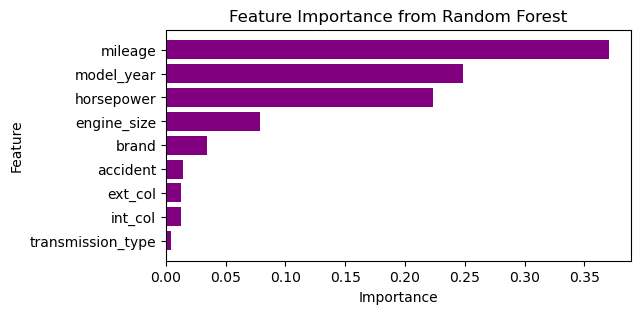

In [24]:
# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 3))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='purple')
plt.gca().invert_yaxis()  # Invert y-axis for highest importance on top
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Model Comparison</h1>
</div>

In [25]:
linear_test = linear_reg_metrics[['Metric', 'Test']]
lasso_test = lasso_cv_metrics[['Metric', 'Test']]
rf_test = rf_metrics[['Metric', 'Test']]

compare_test_metrics = pd.concat([linear_test.set_index('Metric'), 
                                  lasso_test.set_index('Metric'), 
                                  rf_test.set_index('Metric')], axis=1).reset_index()
compare_test_metrics.columns = ['Metric', 'Linear', 'Lasso', 'RF']
compare_test_metrics

,Metric,Linear,Lasso,RF
0,MSE,0.233784,0.235717,0.175462
1,RMSE,0.483512,0.485506,0.418882
2,MAE,0.328941,0.328933,0.275294
3,R²,0.699770,0.697288,0.774668


Random forest wins! 

#
<div class="alert alert-block alert-warning"  style="background-color: #be5bf0; color: black;">  
  <h1>Notes</h1>
</div>

Initially, model performance was very low on any model I tried. I tried a few different things to improve model performance, like switching from random imputation (code for it is below) to KNN imputation. Performance was still low. 

Then, after looking at actual vs. predicted values for some models, it seems like outliers were a problem. I didn't want to just remove them because variation equals information. Also, in the real world, there will be cars that are outliers, so I wanted to include them in my model. I decided to try transforming Y, which made the testing $R^2$ increase to 78%. Without transformations, the best testing $R^2$ I could get with any model was about 50%.   

Takeaway: Try different things!

In [26]:
def impute_random_values(df):
    """ 
    Function to impute missing values with random 
    existing values from respective columns. 

    Advantages of this approach
    --------------------------- 
        - preserves distribution
        - no bias from mean/median

    Parameters
    ----------
    df (pd.DataFrame): DataFrame for which you want to impute values. 

    Returns
    -------
    df (pd.DataFrame): DataFrame with random values imputed. 

    """
    for col in df:
        if df[col].isnull().any():  
            non_null_values = df[col].dropna() 
            df[col] = df[col].apply(lambda x: np.random.choice(non_null_values) if pd.isnull(x) else x)
    return df


In [27]:
import joblib
joblib.dump(rf_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [28]:
print(scaler.feature_names_in_)


['model_year' 'mileage' 'horsepower' 'engine_size']
